In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *
from glob import glob
import warnings
from matplotlib import transforms

2023-12-10 15:28:03.639935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 15:28:03.680777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 15:28:03.680818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 15:28:03.682097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 15:28:03.689702: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_path = os.getcwd() + "/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

In [3]:
def create_predictor_data(data_sets, n_eofs=5):
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)

In [4]:
def create_predictdand_data(data_sets):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y

In [5]:
def get_test_data(file, eof_solvers, n_eofs=5):
    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")
        
    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs

In [6]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [7]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [8]:
def tasGP():
    # Create training and testing arrays
    X_train, eof_solvers = create_predictor_data(train_files)
    y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)
    
    X_test = get_test_data('ssp245', eof_solvers)
    Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
    tas_truth = Y_test["tas"].mean('member')
    
    # Drop rows including nans
    nan_train_mask = X_train.isna().any(axis=1).values
    X_train = X_train.dropna(axis=0, how='any')
    y_train_tas = y_train_tas[~nan_train_mask]
    assert len(X_train) == len(y_train_tas)
    nan_test_mask = X_test.isna().any(axis=1).values
    X_test = X_test.dropna(axis=0, how='any')
    tas_truth = tas_truth[~nan_test_mask]

    # Standardize predictor fields requiring standardization (non-EOFs)
    train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
    train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
    X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
    X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
    X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
    X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

    # Standardize predictand fields
    train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
    y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

    # Make kernel
    kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
    kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
    kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
    kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
    kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

    # Make model
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_tas.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)

    # Define optimizer
    opt = gpflow.optimizers.Scipy()
    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))

    # predict
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
    posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
    posterior_tas_stddev = np.reshape(posterior_stddev, [86, 96, 144])
    
    posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
    posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

    # Compute RMSEs
    print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
    print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
    print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")
    
    # RMSE for average field over last 20 years
    print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

    # plotting predictions
    divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
    diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
    
    ## Temperature
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 3))
    fig.suptitle('Temperature')
    
    # Test
    plt.subplot(131, projection=proj)
    tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"Temperature change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='True')
    
    # Emulator
    plt.subplot(132, projection=proj)
    posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                           cbar_kwargs={"label":"Temperature change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='GP posterior mean')
    
    # Difference
    difference = tas_truth - posterior_tas_data
    plt.subplot(133, projection=proj)
    difference.sel(time=slice(2050,None)).mean('time').plot(
        cmap="bwr",norm=diffnorm,cbar_kwargs={"label":"Temperature change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference')
    return posterior_tas_data

2023-12-10 15:28:14.750386: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13217D+07    |proj g|=  2.67230D+06

At iterate    1    f=  4.82303D+06    |proj g|=  1.26698D+06

At iterate    2    f=  4.48292D+06    |proj g|=  2.01988D+05

At iterate    3    f=  4.43305D+06    |proj g|=  1.95157D+05

At iterate    4    f=  3.96845D+06    |proj g|=  8.74004D+05

At iterate    5    f=  3.66381D+06    |proj g|=  5.16420D+05

At iterate    6    f=  3.56577D+06    |proj g|=  3.42930D+04

At iterate    7    f=  3.55850D+06    |proj g|=  4.04827D+04

At iterate    8    f=  3.55670D+06    |proj g|=  2.25590D+04

At iterate    9    f=  3.55307D+06    |proj g|=  2.53873D+04

At iterate   10    f=  3.54807D+06    |proj g|=  7.91032D+04

At iterate   11    f=  3.54114D+06    |proj g|=  1.08116D+05

At iterate   12    f=  3.53402D+06    |proj g|=  7.39213D+04

At iterate   13    f=  3.5

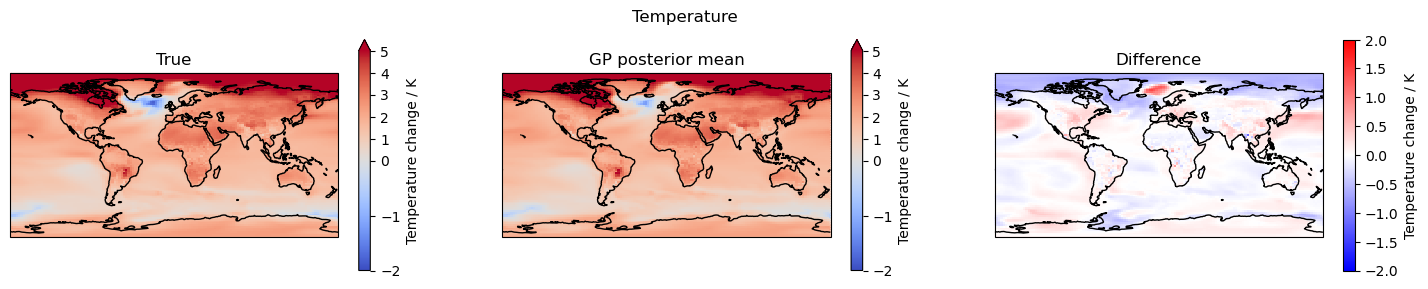

In [9]:
tas_preds = tasGP()

In [10]:
def dtrGP():
    # Create training and testing arrays
    X_train, eof_solvers = create_predictor_data(train_files)
    y_train_dtr = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)
    X_test = get_test_data('ssp245', eof_solvers)
    Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
    dtr_truth = Y_test["diurnal_temperature_range"].mean('member')

    # Drop rows including nans
    nan_train_mask = X_train.isna().any(axis=1).values
    X_train = X_train.dropna(axis=0, how='any')
    y_train_dtr = y_train_dtr[~nan_train_mask]
    assert len(X_train) == len(y_train_dtr)
    nan_test_mask = X_test.isna().any(axis=1).values
    X_test = X_test.dropna(axis=0, how='any')
    dtr_truth = dtr_truth[~nan_test_mask]

    # Standardize predictor fields requiring standardization (non-EOFs)
    train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
    train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
    X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
    X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
    X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
    X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

    # Standardize predictand fields
    train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
    y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

    # Make kernel
    kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
    kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
    kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
    kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
    kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

    # Make model
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_dtr.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)

    # Define optimizer
    opt = gpflow.optimizers.Scipy()
    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))

    # predict
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
    posterior_stddev = np.sqrt(standard_posterior_var) * train_dtr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_dtr_stddev = np.reshape(posterior_stddev, [86, 96, 144])
    posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
    posterior_dtr_std_data = xr.DataArray(posterior_dtr_stddev, dims=dtr_truth.dims, coords=dtr_truth.coords)

    # Compute RMSEs
    print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
    print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
    print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")
    # RMSE for average field over last 20 years
    print(f"RMSE average last 20y: {get_rmse(dtr_truth[-20:].mean(dim='time'), posterior_dtr_data[-20:].mean(dim='time'))}")

    # plotting predictions
    divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
    diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
    
    ## Diurnal Temperature Range
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 3))
    fig.suptitle('DTR')
    
    # Test
    plt.subplot(131, projection=proj)
    dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"DTR change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='True')
    
    # Emulator
    plt.subplot(132, projection=proj)
    posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                           cbar_kwargs={"label":"DTR change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='GP posterior mean')
    
    # Difference
    difference = dtr_truth - posterior_dtr_data
    plt.subplot(133, projection=proj)
    difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                    cbar_kwargs={"label":"DTR change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference')
    return posterior_dtr_data

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26854D+07    |proj g|=  1.84502D+06

At iterate    1    f=  1.11613D+07    |proj g|=  8.94905D+05

At iterate    2    f=  1.09653D+07    |proj g|=  1.25952D+05

At iterate    3    f=  1.09480D+07    |proj g|=  1.22959D+05

At iterate    4    f=  1.08528D+07    |proj g|=  4.55159D+05

At iterate    5    f=  1.06939D+07    |proj g|=  7.28017D+05

At iterate    6    f=  1.05146D+07    |proj g|=  4.80741D+05

At iterate    7    f=  1.04623D+07    |proj g|=  1.05185D+05

At iterate    8    f=  1.04601D+07    |proj g|=  1.46344D+04

At iterate    9    f=  1.04599D+07    |proj g|=  1.13620D+04

At iterate   10    f=  1.04596D+07    |proj g|=  3.15654D+04

At iterate   11    f=  1.04590D+07    |proj g|=  5.30216D+04

At iterate   12    f=  1.04575D+07    |proj g|=  8.47461D+04

At iterate   13    f=  1.0

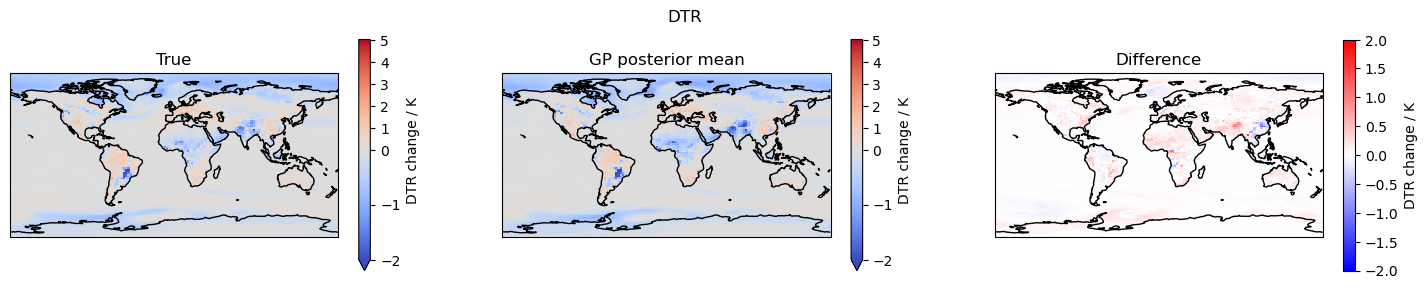

In [11]:
dtr_preds = dtrGP()

In [12]:
def prGP():
    # Create training and testing arrays
    X_train, eof_solvers = create_predictor_data(train_files)
    y_train_pr = create_predictdand_data(train_files)['pr'].values.reshape(-1, 96 * 144)
    X_test = get_test_data('ssp245', eof_solvers)
    Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
    pr_truth = Y_test["pr"].mean('member') * 86400
    
    # Drop rows including nans
    nan_train_mask = X_train.isna().any(axis=1).values
    X_train = X_train.dropna(axis=0, how='any')
    y_train_pr = y_train_pr[~nan_train_mask]
    assert len(X_train) == len(y_train_pr)
    nan_test_mask = X_test.isna().any(axis=1).values
    X_test = X_test.dropna(axis=0, how='any')
    pr_truth = pr_truth[~nan_test_mask]

    # Standardize predictor fields requiring standardization (non-EOFs)
    train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
    train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
    X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
    X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
    X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
    X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

    # Standardize predictand fields
    train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
    y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

    # Make kernel
    kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
    kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
    kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
    kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
    kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

    # Make model
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_pr.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)

    # Define optimizer
    opt = gpflow.optimizers.Scipy()
    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))

    # predict
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
    posterior_stddev = np.sqrt(standard_posterior_var) * train_pr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr_stddev = np.reshape(posterior_stddev, [86, 96, 144])
    posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
    posterior_pr_std_data = xr.DataArray(posterior_pr_stddev, dims=pr_truth.dims, coords=pr_truth.coords)

    # Compute RMSEs
    print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
    print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
    print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")
    # RMSE for average field over last 20 years
    print(f"RMSE average last 20y: {get_rmse(pr_truth[-20:].mean(dim='time'), posterior_pr_data[-20:].mean(dim='time'))}")

    # plotting predictions
    divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
    diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
    
    ## Temperature
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 3))
    fig.suptitle('Precipitation')
    
    # Test
    plt.subplot(131, projection=proj)
    pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"Precip change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='True')
    
    # Emulator
    plt.subplot(132, projection=proj)
    posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                           cbar_kwargs={"label":"Precip change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='GP posterior mean')
    
    # Difference
    difference = pr_truth - posterior_pr_data
    plt.subplot(133, projection=proj)
    difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                    cbar_kwargs={"label":"Precip change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference')
    return posterior_pr_data

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46144D+07    |proj g|=  6.59595D+05

At iterate    1    f=  1.44612D+07    |proj g|=  1.03765D+05

At iterate    2    f=  1.44451D+07    |proj g|=  1.01717D+05

At iterate    3    f=  1.43598D+07    |proj g|=  3.61807D+05

At iterate    4    f=  1.42008D+07    |proj g|=  6.35110D+05

At iterate    5    f=  1.40093D+07    |proj g|=  4.53002D+05

At iterate    6    f=  1.39421D+07    |proj g|=  1.07261D+05

At iterate    7    f=  1.39380D+07    |proj g|=  1.25869D+04

At iterate    8    f=  1.39374D+07    |proj g|=  1.47148D+04

At iterate    9    f=  1.39363D+07    |proj g|=  5.03315D+04

At iterate   10    f=  1.39340D+07    |proj g|=  9.61485D+04

At iterate   11    f=  1.39291D+07    |proj g|=  1.52290D+05

At iterate   12    f=  1.39207D+07    |proj g|=  1.90517D+05

At iterate   13    f=  1.3

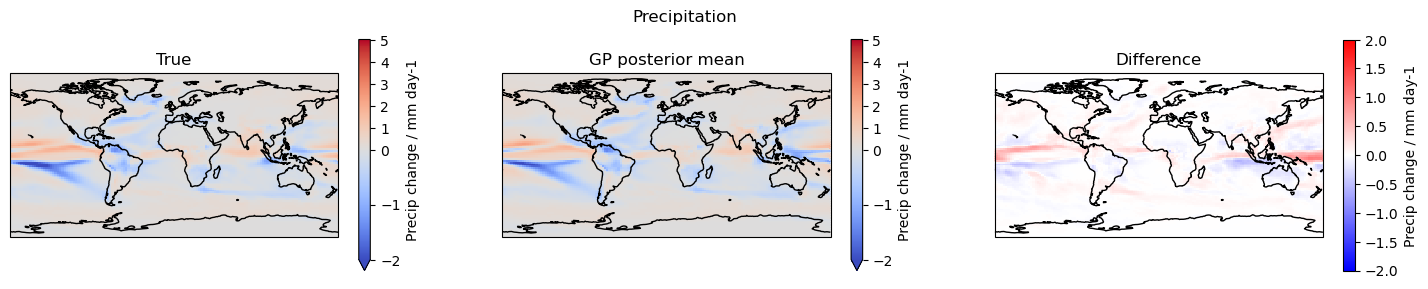

In [13]:
pr_preds = prGP()

In [14]:
def pr90GP():
    # Create training and testing arrays
    X_train, eof_solvers = create_predictor_data(train_files)
    y_train_pr90 = create_predictdand_data(train_files)['pr90'].values.reshape(-1, 96 * 144)
    X_test = get_test_data('ssp245', eof_solvers)
    Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
    pr90_truth = Y_test["pr90"].mean('member') * 86400
    
    # Drop rows including nans
    nan_train_mask = X_train.isna().any(axis=1).values
    X_train = X_train.dropna(axis=0, how='any')
    y_train_pr90 = y_train_pr90[~nan_train_mask]
    assert len(X_train) == len(y_train_pr90)
    nan_test_mask = X_test.isna().any(axis=1).values
    X_test = X_test.dropna(axis=0, how='any')
    pr90_truth = pr90_truth[~nan_test_mask]

    # Standardize predictor fields requiring standardization (non-EOFs)
    train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
    train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()
    X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
    X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std
    X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
    X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

    # Standardize predictand fields
    train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()
    y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

    # Make kernel
    kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
    kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])
    kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
    kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])
    kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

    # Make model
    np.random.seed(5)
    mean = gpflow.mean_functions.Constant()
    model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                    y_train_pr90.astype(np.float64)),
                              kernel=kernel,
                              mean_function=mean)

    # Define optimizer
    opt = gpflow.optimizers.Scipy()
    # Train model
    opt.minimize(model.training_loss,
                 variables=model.trainable_variables,
                 options=dict(disp=True, maxiter=1000))

    # predict
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean
    posterior_stddev = np.sqrt(standard_posterior_var) * train_pr90_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr90_stddev = np.reshape(posterior_stddev, [86, 96, 144])
    posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
    posterior_pr90_std_data = xr.DataArray(posterior_pr90_stddev, dims=pr90_truth.dims, coords=pr90_truth.coords)

    # Compute RMSEs
    print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
    print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
    print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
    print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
    print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")
    # RMSE for average field over last 20 years
    print(f"RMSE average last 20y: {get_rmse(pr90_truth[-20:].mean(dim='time'), posterior_pr90_data[-20:].mean(dim='time'))}")

    # plotting predictions
    divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
    diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
    
    ## Temperature
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 3))
    fig.suptitle('Extreme Precipitation')
    
    # Test
    plt.subplot(131, projection=proj)
    pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                                  cbar_kwargs={"label":"P90 change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='True')
    
    # Emulator
    plt.subplot(132, projection=proj)
    posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                           cbar_kwargs={"label":"P90 change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='GP posterior mean')
    
    # Difference
    difference = pr90_truth - posterior_pr90_data
    plt.subplot(133, projection=proj)
    difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                    cbar_kwargs={"label":"P90 change / mm day-1"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference')
    return posterior_pr90_data

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46798D+07    |proj g|=  6.21221D+05

At iterate    1    f=  1.45440D+07    |proj g|=  1.01968D+05

At iterate    2    f=  1.45285D+07    |proj g|=  9.99489D+04

At iterate    3    f=  1.44452D+07    |proj g|=  3.58827D+05

At iterate    4    f=  1.42922D+07    |proj g|=  6.25518D+05

At iterate    5    f=  1.41021D+07    |proj g|=  4.52557D+05

At iterate    6    f=  1.40326D+07    |proj g|=  1.06766D+05

At iterate    7    f=  1.40282D+07    |proj g|=  1.22619D+04

At iterate    8    f=  1.40276D+07    |proj g|=  1.43959D+04

At iterate    9    f=  1.40264D+07    |proj g|=  4.71371D+04

At iterate   10    f=  1.40240D+07    |proj g|=  9.25431D+04

At iterate   11    f=  1.40186D+07    |proj g|=  1.48191D+05

At iterate   12    f=  1.40100D+07    |proj g|=  1.84034D+05

At iterate   13    f=  1.4

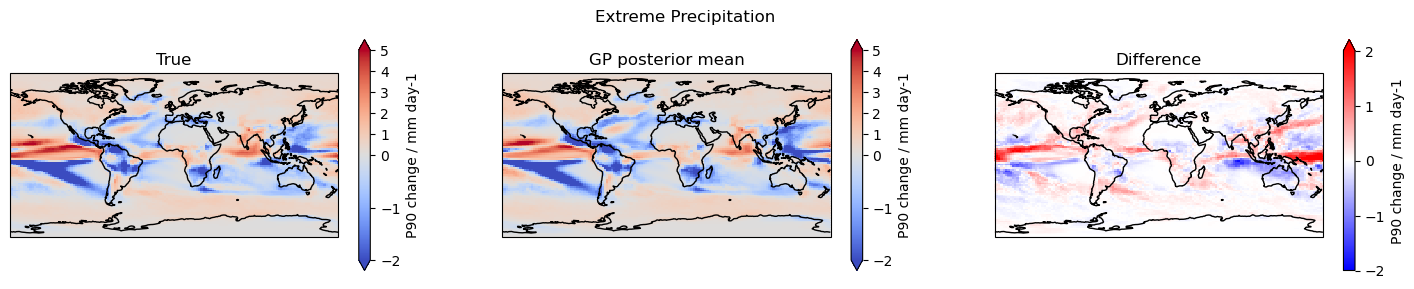

In [15]:
pr90_preds = pr90GP()

In [47]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

inputs = glob(data_path + "inputs_s*.nc")

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])

In [48]:
all_inputs = glob(data_path + "inputs_*.nc")
global_means = {}

def global_total(da):
    if 'latitude' in da.coords:
        if da.name in ['CO2', 'CH4', 'tas']:
            return global_mean(da)
        else:
            return convert(global_sum(da*AREA_of_EARTH*1000*100))
    else:
        return da

for inp in glob(data_path + "inputs_*.nc"):
    label=inp.split('_')[1][:-3]
    X = xr.open_dataset(inp)
    Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
#     print(X.coords)
    print(label)
#     if label == "hist-aer":
#         X = X.rename_vars({"CO4": "CO2"})
    if 'lat' in X.coords:
        X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'lat' in Y.coords:
        Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

    if label == "abrupt-4xCO2":
        X = X.sel(time=slice(None, None, 5))
    X['tas'] = Y['tas'].mean('member')
    
    global_means[label] = X.map(global_total).to_pandas()

1pctCO2
abrupt-4xCO2
ssp126
ssp370-lowNTCF
hist-GHG
historical
hist-aer
ssp370
ssp245
ssp585


In [49]:
tas_preds.name = 'tas'
dtr_preds.name = 'diurnal_temperature_range'
pr_preds.name = 'pr'
pr90_preds.name = 'pr90'

In [50]:
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()
Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [51]:
gp_predictions = xr.merge([tas_preds, dtr_preds, pr_preds, pr90_preds])

In [52]:
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
models = [gp_predictions, Y.mean('member')]
model_labels = ['Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-2, vmax=2), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

In [53]:
proj = ccrs.PlateCarree()

[[<GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: >]
 [<GeoAxes: > <GeoAxes: >]]


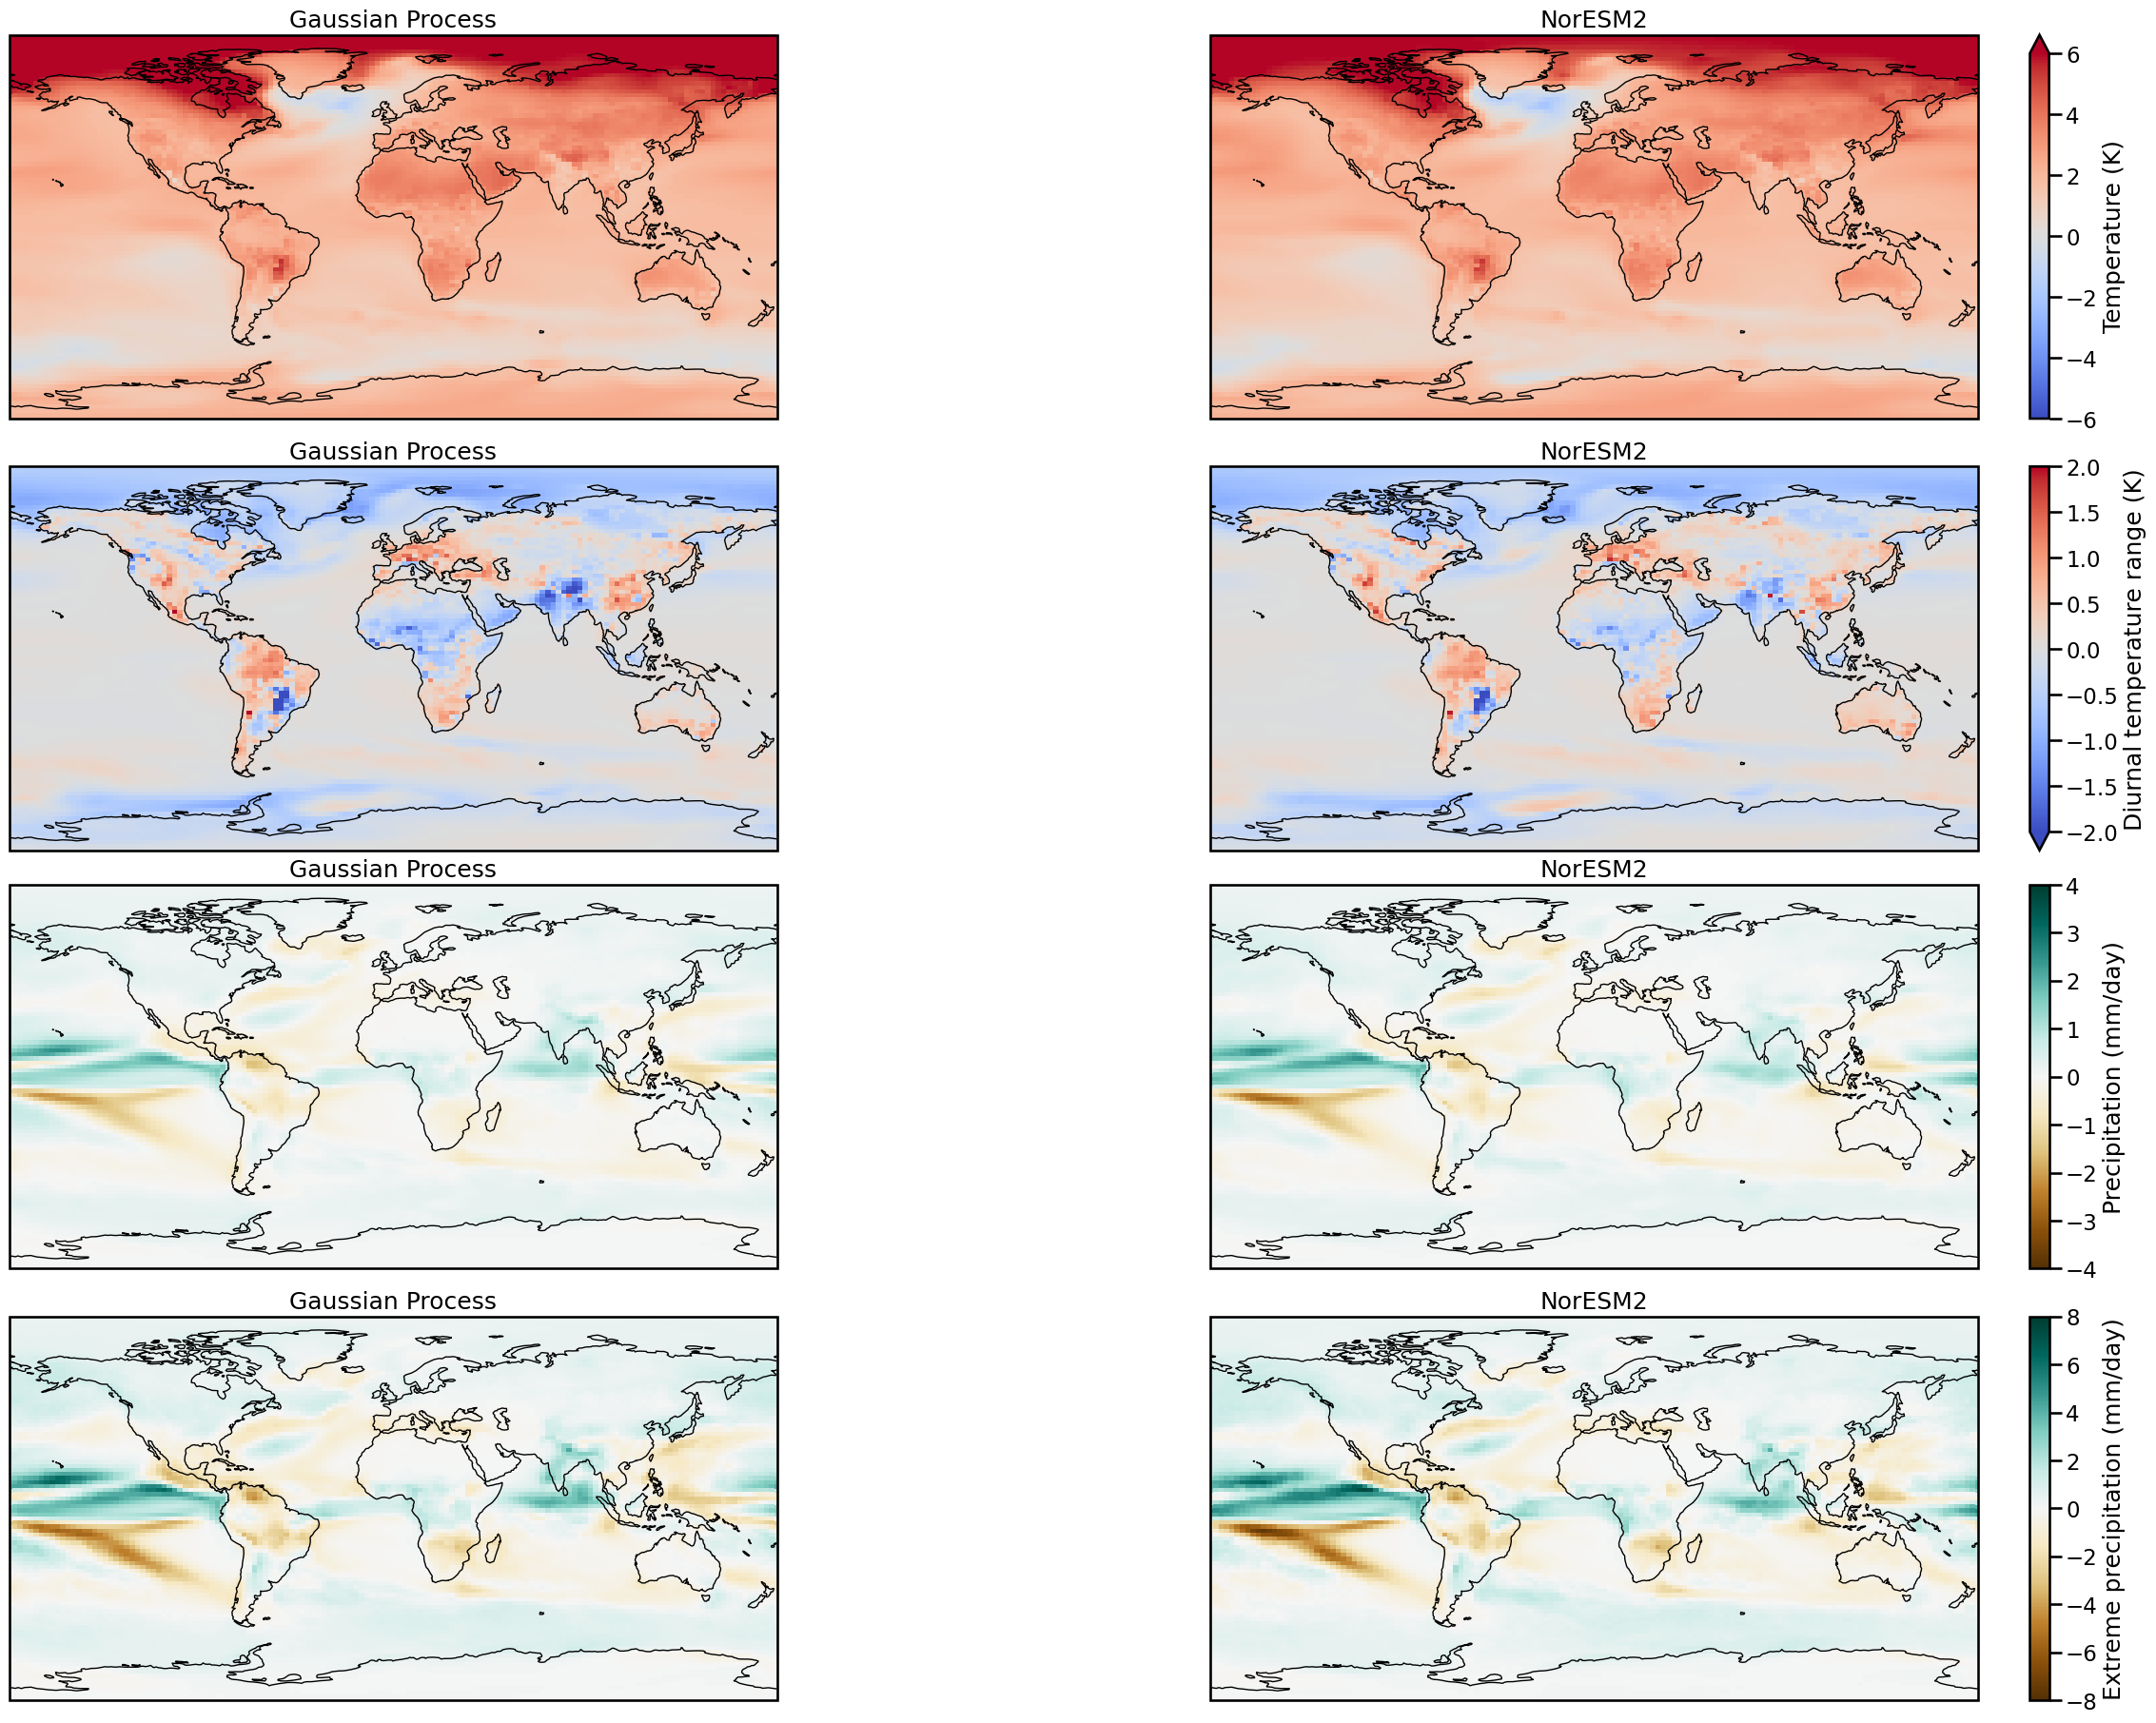

In [54]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4, 2, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models, model_labels):
            ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2080, 2100)).mean(['time']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2080, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()

    plt.savefig("GP_Nor.png")

In [26]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

[<GeoAxes: > <GeoAxes: > <GeoAxes: > <GeoAxes: >]
tas Temperature (K) Gaussian Process
diurnal_temperature_range Diurnal temperature range (K) Gaussian Process
pr Precipitation (mm/day) Gaussian Process
pr90 Extreme precipitation (mm/day) Gaussian Process


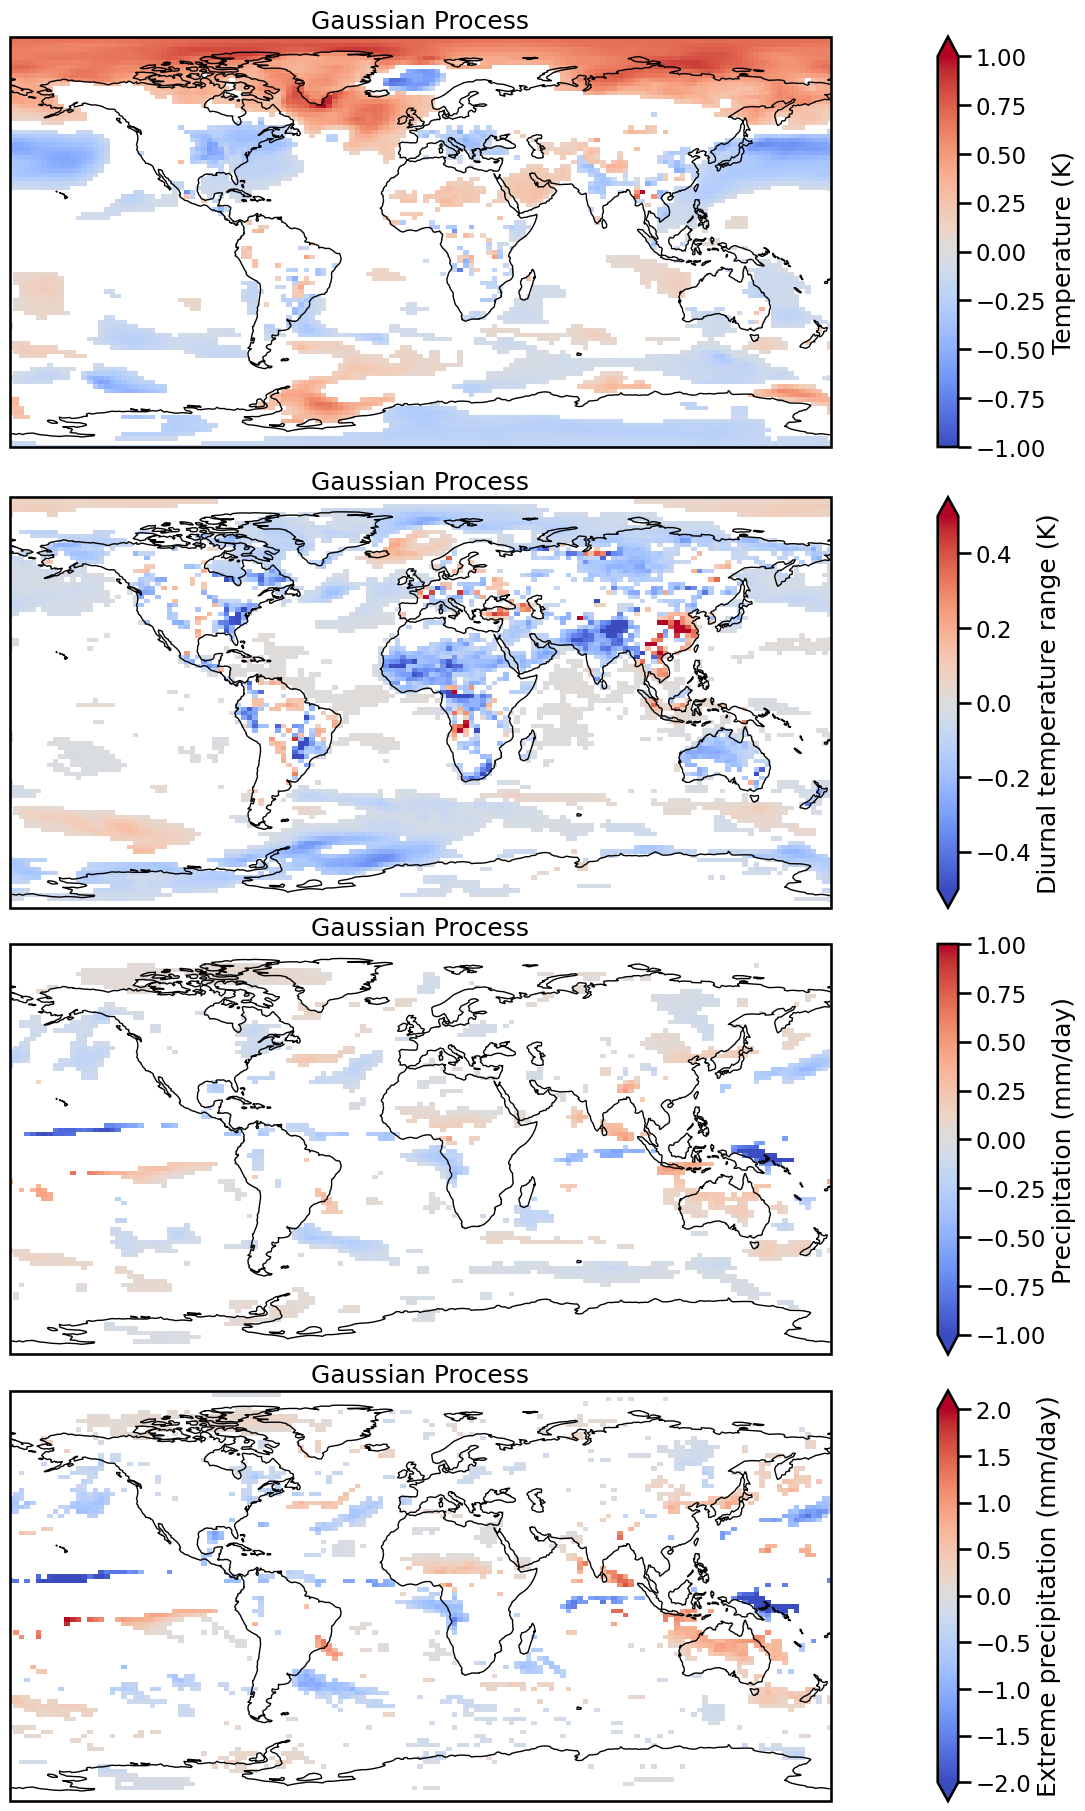

In [35]:
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(4, 1, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(ax)
    model = models[0]
    model_label = model_labels[0]
    count = 0
    for var, label, kws in zip(variables, labels, kwargs):
        print(var, label, model_label)
        ax[count].set_title(model_label)
        diff = (model[var]-models[1][var]).sel(time=slice(2080, 2100)) # /models[-1][var]
        mean_diff = diff.mean('time')
        _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
        if model_label == 'Gaussian Process':
            mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax[count], add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
        else:
            mean_diff.where(p < p_level).plot(cmap="coolwarm", ax=ax[count], add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
        ax[count].coastlines()
        count += 1
    
    plt.savefig("GP_Diff.png")

In [28]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

In [29]:
from xskillscore import rmse, pearson_r, spearman_r, r2, smape, mae, me, mse
weights = np.cos(np.deg2rad(Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=Y.lon)

In [30]:
R2E = pd.DataFrame({
    label: {variable: rmse( global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
#                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                           for label, model in zip(model_labels[0:2], models[0:1])
})
R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,diurnal_temperature_range,pr,pr90,tas
Gaussian Process,2.6480,0.3800,0.4480,0.0400


In [31]:
NRMSE = pd.DataFrame({
    label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                               model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    for label, model in zip(model_labels[:-1], models[:-1])
})
NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,diurnal_temperature_range,pr,pr90,tas
Gaussian Process,9.1870,2.3340,2.7100,0.0920


In [32]:
(NRMSE+5*R2E).T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")

,diurnal_temperature_range,pr,pr90,tas
Gaussian Process,22.4270,4.2330,4.9500,0.2910


In [33]:
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total']).T

In [34]:
combined_df

Spatial                                \
                 diurnal_temperature_range        pr      pr90       tas   
Gaussian Process                  9.187393  2.334224  2.710133  0.091905   

                                    Global                               \
                 diurnal_temperature_range        pr      pr90      tas   
Gaussian Process                  2.648009  0.379696  0.447995  0.03984   

                                     Total                                
                 diurnal_temperature_range        pr      pr90       tas  
Gaussian Process                 22.427437  4.232703  4.950108  0.291106

In [45]:
import dataframe_image as dfi
dfi.export(combined_df, 'GP_NRMSE.png',table_conversion='matplotlib')